In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
import tensorflow as tf
import os

In [2]:
tf.config.list_physical_devices('GPU')

2022-02-08 16:43:48.814669: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-08 16:43:48.814701: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (power): /proc/driver/nvidia/version does not exist


[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [53]:
import talib

# Load data

In [5]:
data = pd.read_csv('../data/data_lexical_decision.csv', sep=',', header=0)

In [6]:
data.head()

,id,sex,age,session,block,trial,stim_type,stim,resp,acc,rt
0,1,1,21,1,1,5,2,Bamahun,2,1,0.847
1,1,1,21,1,1,6,2,Wernir,2,1,0.654
2,1,1,21,1,1,7,3,Wsboaä,2,1,0.647
3,1,1,21,1,1,8,1,Leiste,1,1,0.543
4,1,1,21,1,1,9,0,dauern,1,1,0.591


In [54]:
def inspect_person(which_id=2, plot_raw=False, figsize=(16, 6)):
    """
    Plot RT (summaries) over time for a given person id.
    """
    
    person = data[data.id == which_id]
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    time = np.arange(person.shape[0])
    
    if plot_raw:
        ax.plot(time, person.rt, alpha=0.2, label='Raw RTs')
    ax.plot(time, talib.EMA(person.rt, timeperiod=100), color='red', lw=3, label='EMA100')
    ax.plot(time, talib.EMA(person.rt, timeperiod=50), color='green', lw=2, label='EMA50', alpha=0.5)
    ax.plot(time, talib.EMA(person.rt, timeperiod=9), color='blue', lw=1, label='EMA9', alpha=0.2)

    for idx in np.argwhere(person.session.diff().values == 1):
        ax.axvline(idx, color='black', linestyle='dashed', alpha=0.5)
    sns.despine(ax=ax)
    ax.grid(alpha=0.2)
    ax.legend()

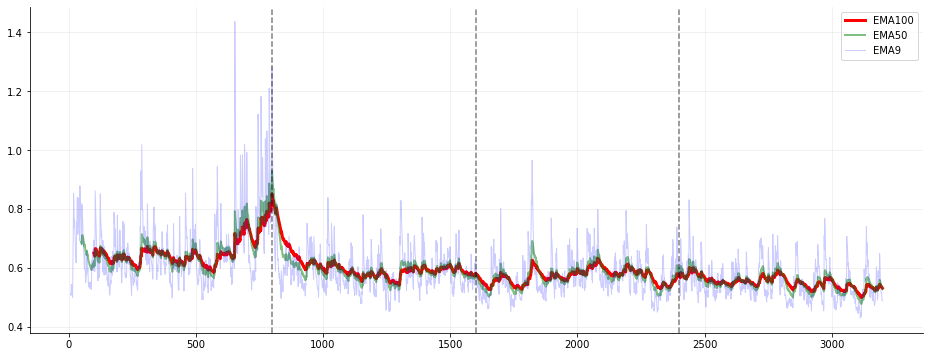

In [55]:
inspect_person(which_id=2)

In [58]:
person = data[data.id == 2]
# person = person[person.session==1]
person.shape

(3200, 11)

In [26]:
EXP_STRUCTURE = person.stim_type.values
N_OBS = EXP_STRUCTURE.shape[0]

# Simulator

In [27]:
def dynamic_prior(batch_size, **args):
    """
    Generates a random draw from the diffusion model prior.
    """
    
    v1 = np.random.uniform(0.3, 6.0, batch_size)
    v2 = np.random.uniform(0.3, 6.0, batch_size)
    v3 = np.random.uniform(0.3, 6.0, batch_size)
    v4 = np.random.uniform(0.3, 6.0, batch_size)
    a = np.random.uniform(0.3, 2.5, batch_size)
    ndt = np.random.uniform(0.1, 1.6, batch_size)
    v1_s = np.random.uniform(0.01, 0.1, batch_size)
    v2_s = np.random.uniform(0.01, 0.1, batch_size)
    v3_s = np.random.uniform(0.01, 0.1, batch_size)
    v4_s = np.random.uniform(0.01, 0.1, batch_size)
    a_s = np.random.uniform(0.01, 0.1, batch_size)
    ndt_s = np.random.uniform(0.01, 0.1, batch_size)
    return np.c_[v1, v2, v3, v4, a, ndt, v1_s, v2_s, v3_s, v4_s, a_s, ndt_s]

@njit
def diffusion_trial(v, a, ndt, zr=0.5, dt=0.001, s=1.0, max_iter=1e4):
    """
    Simulates a single reaction time from a simple drift-diffusion process.
    """

    n_iter = 0
    x = a * zr
    c = np.sqrt(dt * s)
    
    while x > 0 and x < a:
        
        # DDM equation
        x += v*dt + c * np.random.randn()
        
        # 
        n_iter += 1
        
    rt = n_iter * dt
    return rt+ndt if x > 0 else -(rt+ndt)

@njit
def dynamic_diffusion_process(prior_samples, n_obs, dt=0.001, s=1.0, max_iter=1e4):
    """
    Performs one run of a dynamic diffusion model process.
    """
    
    params, params_stds = np.split(prior_samples, 2, axis=-1)
    params_t = params
    
    params_t_array = np.zeros((n_obs, params.shape[0]))
    
    # Draw first param combination from prior
    rts_v = np.zeros(n_obs)
    
    # Iterate over number of trials
    for t in range(n_obs):
        
        # Run diffusion process
        rts_v[t] = diffusion_trial(params_t[EXP_STRUCTURE[t]], params_t[4], params_t[5])
        
        # Store before transition
        params_t_array[t] = params_t
        
        # Transition and ensure non-negative parameters
        params_t = params_t + params_stds * np.random.randn(params.shape[0])
        
        # Constraints
        params_t[0] = min(max(params_t[0], 0.3), 6)
        params_t[1] = min(max(params_t[1], 0.3), 6)
        params_t[2] = min(max(params_t[2], 0.3), 6)
        params_t[3] = min(max(params_t[3], 0.3), 6)
        params_t[4] = min(max(params_t[4], 0.3), 2.5)
        params_t[5] = min(max(params_t[5], 0.1), 1.6)
        
    return np.atleast_2d(rts_v).T, params_t_array, params_stds

@njit
def batch_simulator(prior_samples, n_obs, dt=0.001, s=1.0, max_iter=1e4):
    
    B = prior_samples.shape[0]
    X = np.zeros((B, n_obs, 1))
    theta_d = np.zeros((B, n_obs, 6))
    theta_s = np.zeros((B, 6))
    for bi in range(B):
        X[bi], theta_d[bi], theta_s[bi] = dynamic_diffusion_process(prior_samples[bi], 
                                                                    n_obs,
                                                                    dt=dt, s=s, 
                                                                    max_iter=max_iter)
    return X, theta_d, theta_s

In [31]:
%%time
X, theta_d, theta_s = batch_simulator(dynamic_prior(16), N_OBS)

CPU times: user 400 ms, sys: 3.93 ms, total: 404 ms
Wall time: 402 ms


# Amortizers

In [32]:
import tensorflow as tf

In [33]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [34]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

## Network Architecture

In [35]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d, n_params_s):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])
        
        
        self.static_predictor = Sequential([
            LSTM(n_params_s),
            Dense(tfpl.MultivariateNormalTriL.params_size(n_params_s)),
            tfpl.MultivariateNormalTriL(n_params_s)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic stuff
        preds_dyn = self.dynamic_predictor(rep)
        
        # Predict static
        preds_stat = self.static_predictor(rep)
        
        return preds_dyn, preds_stat

## Loss

In [36]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

## Epoch helper

In [37]:
def train_epoch(network, optimizer, batch_size, steps_per_epoch, p_bar):
    
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            

            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            x_t, params_t, params_s = batch_simulator(prior_draws, N_OBS)
            pred_params_t, pred_params_s = network(x_t)

            # Loss dynamic and static
            loss_d = nll(np.log(params_t), pred_params_t)
            loss_s = nll(np.log(params_s), pred_params_s)

            total_loss = loss_d + loss_s
            
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f}, Loss S: {:.3f}, Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), loss_s.numpy(), np.mean(losses)))
        p_bar.update(1)

## Train

In [38]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [41]:
batch_size = 8
steps_per_epoch = 1000
network = HeteroscedasticNetwork(6, 6)

In [50]:
# Reminder for a humanoid memoryless process: Whenever the loss does not improve, reduce learning rate by half and run for 10 epochs or so
epochs = 10
learning_rate = 0.00005
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [51]:
for ep in range(1, epochs+1):
    with tqdm(total=steps_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        train_epoch(network, optimizer, batch_size, steps_per_epoch, p_bar)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
network.save_weights('checkpoints/dynamic_second')

# Inference

In [59]:
@njit
def dynamic_generator(params_t, n_obs, dt=0.001, s=1.0, max_iter=1e4):
    """
    Performs one run of a dynamic diffusion model process.
    """
    
    rts_v = np.zeros(n_obs)
    for t in range(n_obs):
        rts_v[t] = diffusion_trial(params_t[t, EXP_STRUCTURE[t]], params_t[t, 4], params_t[t, 5])
    return rts_v

In [60]:
rts = person.rt.values.copy()
acc = person.acc.values.copy()

In [61]:
rts[acc == 0] = -rts[acc == 0]

In [62]:
x_nn = rts[np.newaxis, :, np.newaxis]

In [63]:
post_t, post_s = network(x_nn)

In [69]:
post_t.shape

TensorShape([1, 3200, 6])

In [146]:
# post_t_mean = np.exp(post_t.mean())
# post_s_mean = np.exp(post_s.mean())

In [125]:
sim_data = []
n_sim = 20
n_post_samples = 20
post_samples_t = np.exp(post_t.sample(n_post_samples))[:, 0, :, :]
for pi in range(n_post_samples):
    for _ in range(n_sim):
        x_pred = dynamic_generator(post_samples_t[pi], N_OBS)
        sim_data.append(talib.SMA(np.abs(x_pred), timeperiod=5))
sim_data = np.abs(np.array(sim_data))

In [126]:
quantiles = np.quantile(sim_data, [0.05, 0.95], axis=0)
median = np.median(sim_data, axis=0)
mean = np.mean(sim_data, axis=0)

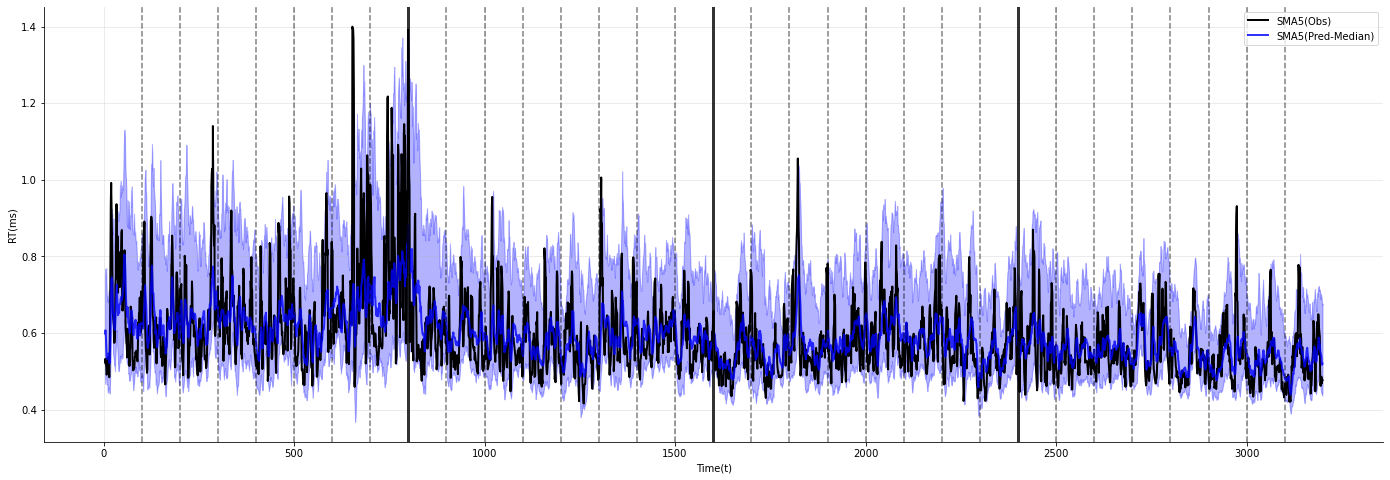

In [127]:
# Initialize figure
f, ax = plt.subplots(1, 1, figsize=(24, 8))

# Plot observed
time = np.arange(x_nn.shape[1])
ax.plot(time, talib.SMA(np.abs(x_nn[0, :, 0]), timeperiod=5), color='black', lw=2, label='SMA5(Obs)')
ax.plot(time, median, color='blue', lw=2, label='SMA5(Pred-Median)', alpha=0.8)
ax.fill_between(time, quantiles[0, :], quantiles[1, :], color='blue', alpha=0.3)
for idx in np.argwhere(person.session.diff().values == 1):
    ax.axvline(idx, color='black', linestyle='solid', lw=3, alpha=0.8)
for idx in np.argwhere(person.block.diff().values == 1):
    ax.axvline(idx, color='black', linestyle='dashed', alpha=0.5)
sns.despine(ax=ax)
ax.grid(alpha=0.3)
ax.set_ylabel('RT(ms)')
ax.set_xlabel('Time(t)')
ax.legend()

# Dynamic parameters 

In [94]:
n_post_samples = 250
post_samples_t = np.exp(post_t.sample(n_post_samples))[:, 0, :, :]
post_samples_t.shape

(250, 3200, 6)

In [121]:
which_param = -2

In [122]:
quantiles = np.quantile(post_samples_t[:, :, which_param], [0.05, 0.95], axis=0)
median = np.median(post_samples_t[:, :, which_param], axis=0)
quantiles.shape

(2, 3200)

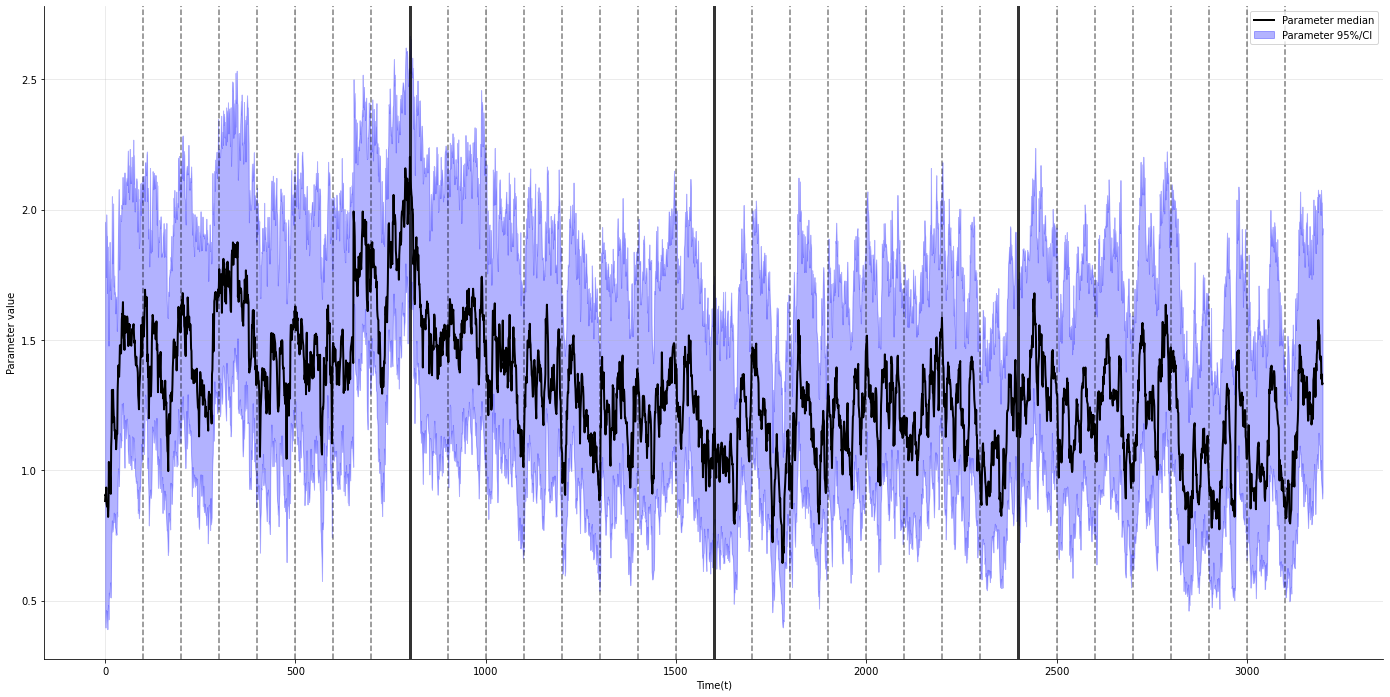

In [123]:
# Initialize figure
f, ax = plt.subplots(1, 1, figsize=(24, 12))

time = np.arange(post_samples_t.shape[1])
ax.plot(time, median, color='black', lw=2, label='Parameter median')
ax.fill_between(time, quantiles[0, :], quantiles[1, :], color='blue', alpha=0.3, label='Parameter 95%/CI')
for idx in np.argwhere(person.session.diff().values == 1):
    ax.axvline(idx, color='black', linestyle='solid', lw=3, alpha=0.8)
for idx in np.argwhere(person.block.diff().values == 1):
    ax.axvline(idx, color='black', linestyle='dashed', alpha=0.5)
sns.despine(ax=ax)
ax.grid(alpha=0.3)
ax.set_ylabel('Parameter value')
ax.set_xlabel('Time(t)')
ax.legend()